In [85]:
import pandas as pd

def read_csv(file_path):
    df = pd.read_csv(file_path)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

df = read_csv("stock_data.csv");
print(df)

       Symbol Series         Date  Prev Close  Open Price  High Price  \
0    RELIANCE     EQ  31-Jan-2022     2335.85     2360.20     2406.40   
1    RELIANCE     EQ  01-Feb-2022     2386.60     2408.00     2420.60   
2    RELIANCE     EQ  02-Feb-2022     2378.70     2407.00     2407.00   
3    RELIANCE     EQ  03-Feb-2022     2383.55     2392.00     2401.45   
4    RELIANCE     EQ  04-Feb-2022     2352.75     2341.00     2348.45   
..        ...    ...          ...         ...         ...         ...   
249  RELIANCE     EQ  23-Jan-2023     2442.65     2449.00     2466.20   
250  RELIANCE     EQ  24-Jan-2023     2430.30     2440.00     2443.65   
251  RELIANCE     EQ  25-Jan-2023     2415.95     2412.45     2414.70   
252  RELIANCE     EQ  27-Jan-2023     2382.55     2384.40     2387.35   
253  RELIANCE     EQ  30-Jan-2023     2337.35     2331.70     2371.90   

     Low Price  Last Price  Close Price  Average Price  Total Traded Quantity  \
0      2356.20     2384.05      2386.60   

    Symbol Series         Date  Prev Close  Open Price  High Price  Low Price  \
19  HATSUN     EQ  26-Feb-2021      711.45       739.7       739.7      705.5   

    Last Price  Close Price  Average Price  ...  lower_band        RSI  \
19       706.7       716.95         724.66  ...  700.078565  44.320388   

    26_day_ema  12_day_ema      MACD  signal_line         %K         %D  \
19  715.465146  714.456517 -1.008629    -0.998819  41.493384  38.405797   

    Price_times_volume        VWAP  
19         63695988.85  718.411404  

[1 rows x 27 columns]
Linear Regression Results:
Predicted price: 84      861.309395
417    1060.756069
194    1360.204651
335     882.963402
128     942.927648
          ...     
427     997.862237
397    1043.570472
222    1302.651111
119     943.825128
294    1096.266770
Length: 96, dtype: float64
Expected price movement direction accuracy: 1.0

Support Vector Regression Results:
Predicted price: 84     989.424872
417    989.091682
194    989.851466
335  

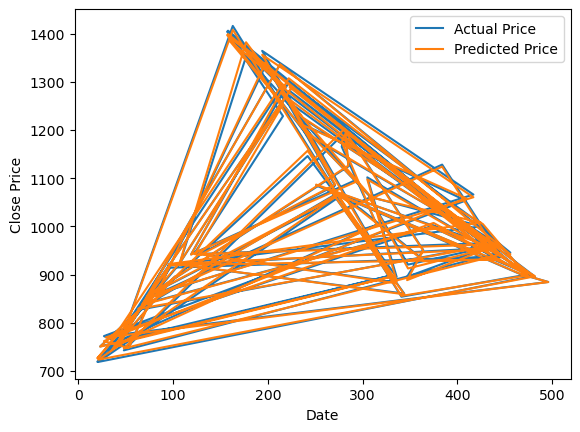

In [7]:
import pandas as pd
import numpy as np

def read_csv(file_path):
    df = pd.read_csv(file_path)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

def calculate_ADX(df, n=14):
    UpI = []
    DoI = []
    for i in range(len(df) - 1):
        UpMove = df['High Price'].iloc[i + 1] - df['High Price'].iloc[i]
        DoMove = df['Low Price'].iloc[i] - df['Low Price'].iloc[i + 1]
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
    TR_l = [0]
    for i in range(len(df) - 1):
        TR = max(df['High Price'].iloc[i + 1], df['Close Price'].iloc[i]) - min(df['Low Price'].iloc[i + 1], df['Close Price'].iloc[i])
        TR_l.append(TR)
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n, min_periods=n).mean(), name='ADX_' + str(n))
    df = df.join(ADX)
    return df


def clean_df(df):
    #df = df.applymap(lambda x: np.nan if isinstance(x, str) else x)
    #df = df.dropna()
    #df = df[~df.isin([np.inf, -np.inf]).any(1)]
    #df = df.applymap(lambda x: np.nan if x > 1e10 else x)
    df = df.dropna()
    return df

def calculate_indicators(df):
    # 7-day moving average
    df['7_day_ma'] = df['Close Price'].rolling(window=7).mean()

    # 14-day moving average
    df['14_day_ma'] = df['Close Price'].rolling(window=14).mean()

    # Bollinger Bands
    df['rolling_std'] = df['Close Price'].rolling(window=20).std()
    df['upper_band'] = df['14_day_ma'] + 2 * df['rolling_std']
    df['lower_band'] = df['14_day_ma'] - 2 * df['rolling_std']

    # Relative Strength Index (RSI)
    delta = df['Close Price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    df['26_day_ema'] = df['Close Price'].ewm(span=26).mean()
    df['12_day_ema'] = df['Close Price'].ewm(span=12).mean()
    df['MACD'] = df['12_day_ema'] - df['26_day_ema']
    df['signal_line'] = df['MACD'].ewm(span=9).mean()

    # Stochastic Oscillator
    L14 = df['Low Price'].rolling(window=14).min()
    H14 = df['High Price'].rolling(window=14).max()
    df['%K'] = 100 * (df['Close Price'] - L14) / (H14 - L14)
    df['%D'] = df['%K'].rolling(window=3).mean()

    # Average Directional Movement Index (ADX)
    #df['ADX']=calculate_ADX(df, n=14)
    #print("------------------------------------------>",minus_delta,"<--This is--------")

    #Volume Weighted Average Price (VWAP)
    df['Price_times_volume'] = df['Close Price'] * df['Total Traded Quantity']
    df['VWAP'] = df['Price_times_volume'].cumsum() / df['Total Traded Quantity'].cumsum()
    return df

df = read_csv("stock_data.csv");


#print(type(df),"-------------> ",df.head)

#df=clean_df(df)

#print("xx------------------------------------------------------------------------------------------------------------xx ")

#print(type(df),"-------------> ",df.tail(10))


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def predict_price(df):
    df = df.dropna() # remove any rows with missing values
    X = df[['Prev Close','Open Price','High Price','Low Price','Last Price','Total Traded Quantity','lower_band','RSI','26_day_ema','12_day_ema','MACD','signal_line','%K','%D','Price_times_volume','VWAP']]
    y = df['Close Price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Fit multiple machine learning models
    models = [
        ('Linear Regression', LinearRegression()),
        ('Support Vector Regression', SVR()),
        ('Decision Tree Regression', DecisionTreeRegressor()),
        ('Random Forest Regression', RandomForestRegressor())
    ]

    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate the movement direction based on difference between predicted and actual prices
        y_test_movement = (y_test > y_test.shift(1)).astype(int)
        y_pred = pd.Series(y_pred, index=y_test.index)
        y_pred_movement = (y_pred > y_pred.shift(1)).astype(int)
        correct_movement = (y_test_movement == y_pred_movement).mean()

        print(f"{name} Results:")
        if len(y_test) > 0:
            print(f"Predicted price: {y_pred[-len(y_test):]}")
            print(f"Expected price movement direction accuracy: {correct_movement}")
        else:
            print("Not enough data to predict price")
        print("")

    # Plot actual vs predicted prices over time
    if len(y_test) > 0:
        plt.plot(y_test.index, y_test, label='Actual Price')
        plt.plot(y_test.index, y_pred[-len(y_test):], label='Predicted Price')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.show()

df=calculate_indicators(df);
df=clean_df(df)
print(df.head(1))
predict_price(df)





Predicted price: 1336.4354999999998
Expected price movement direction: Up


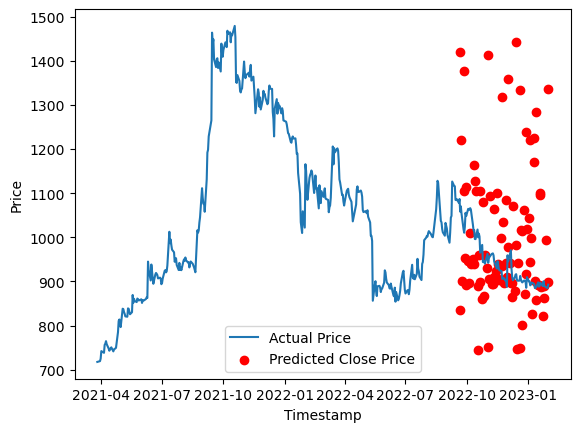

In [6]:
import pandas as pd
import numpy as np

def read_csv(file_path):
    df = pd.read_csv(file_path)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

def clean_df(df):
    #df = df.applymap(lambda x: np.nan if isinstance(x, str) else x)
    #df = df.dropna()
    #df = df[~df.isin([np.inf, -np.inf]).any(1)]
    #df = df.applymap(lambda x: np.nan if x > 1e10 else x)
    df = df.dropna()
    return df

def calculate_indicators(df):
    # 7-day moving average
    df['7_day_ma'] = df['Close Price'].rolling(7).mean()

    # 14-day moving average
    df['14_day_ma'] = df['Close Price'].rolling(14).mean()

    # Bollinger Bands
    df['rolling_std'] = df['Close Price'].rolling(20).std()
    df['upper_band'] = df['14_day_ma'] + 2 * df['rolling_std']
    df['lower_band'] = df['14_day_ma'] - 2 * df['rolling_std']

    # Relative Strength Index (RSI)
    delta = df['Close Price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    df['26_day_ema'] = df['Close Price'].ewm(26).mean()
    df['12_day_ema'] = df['Close Price'].ewm(12).mean()
    df['MACD'] = df['12_day_ema'] - df['26_day_ema']
    df['signal_line'] = df['MACD'].ewm(9).mean()

    # Stochastic Oscillator
    L14 = df['Low Price'].rolling(14).min()
    H14 = df['High Price'].rolling(14).max()
    df['%K'] = 100 * (df['Close Price'] - L14) / (H14 - L14)
    df['%D'] = df['%K'].rolling(3).mean()

    # Average Directional Movement Index (ADX)
    #df['ADX']=calculate_ADX(df, n=14)
    #print("------------------------------------------>",minus_delta,"<--This is--------")

    #Volume Weighted Average Price (VWAP)
    df['Price_times_volume'] = df['Close Price'] * df['Total Traded Quantity']
    df['VWAP'] = df['Price_times_volume'].cumsum() / df['Total Traded Quantity'].cumsum()
    return df

df = read_csv("stock_data.csv");


#print(type(df),"-------------> ",df.head)

#df=clean_df(df)

#print("xx------------------------------------------------------------------------------------------------------------xx ")

#print(type(df),"-------------> ",df.tail(10))


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import pandas as pd
import numpy as np

def read_csv(file_path):
    df = pd.read_csv(file_path)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df


def clean_df(df):
    #df = df.applymap(lambda x: np.nan if isinstance(x, str) else x)
    #df = df.dropna()
    #df = df[~df.isin([np.inf, -np.inf]).any(1)]
    #df = df.applymap(lambda x: np.nan if x > 1e10 else x)
    df = df.dropna()
    return df

def calculate_indicators(df):
    # 7-day moving average
    df['7_day_ma'] = df['Close Price'].rolling(7).mean()

    # 14-day moving average
    df['14_day_ma'] = df['Close Price'].rolling(14).mean()

    # Bollinger Bands
    df['rolling_std'] = df['Close Price'].rolling(20).std()
    df['upper_band'] = df['14_day_ma'] + 2 * df['rolling_std']
    df['lower_band'] = df['14_day_ma'] - 2 * df['rolling_std']

    # Relative Strength Index (RSI)
    delta = df['Close Price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    df['26_day_ema'] = df['Close Price'].ewm(26).mean()
    df['12_day_ema'] = df['Close Price'].ewm(12).mean()
    df['MACD'] = df['12_day_ema'] - df['26_day_ema']
    df['signal_line'] = df['MACD'].ewm(9).mean()

    # Stochastic Oscillator
    L14 = df['Low Price'].rolling(14).min()
    H14 = df['High Price'].rolling(14).max()
    df['%K'] = 100 * (df['Close Price'] - L14) / (H14 - L14)
    df['%D'] = df['%K'].rolling(3).mean()

    # Average Directional Movement Index (ADX)
    #df['ADX']=calculate_ADX(df, n=14)
    #print("------------------------------------------>",minus_delta,"<--This is--------")

    #Volume Weighted Average Price (VWAP)
    df['Price_times_volume'] = df['Close Price'] * df['Total Traded Quantity']
    df['VWAP'] = df['Price_times_volume'].cumsum() / df['Total Traded Quantity'].cumsum()
    return df

df=calculate_indicators(df);
df=clean_df(df)

#print(type(df),"-------------> ",df.head)

#df=clean_df(df)

#print("xx------------------------------------------------------------------------------------------------------------xx ")

#print(type(df),"-------------> ",df.tail(10))

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def predict_price(df):
    # Convert the Date column to timestamps and use it as the index
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

    # Use features lower_band,RSI,26_day_ema,12_day_ema,MACD,signal_line,%K,%D,Price_times_volume,VWAP
    X = df[['lower_band', 'RSI', '26_day_ema', '12_day_ema', 'MACD', 'signal_line', '%K', '%D', 'Price_times_volume', 'VWAP']]
    y = df['Close Price']

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    from sklearn.metrics import mean_squared_error

# ...

    models = [LinearRegression(), RandomForestRegressor(random_state=42), SVR()]
    mse_values = []
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_values.append(mse)

    best_model_index = mse_values.index(min(mse_values))
    best_model = models[best_model_index]

# ...

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Fit models and make predictions
#     regressors = {'Random Forest': RandomForestRegressor(random_state=42),
#                   'Support Vector Regression': SVR(),
#                   'Linear Regression': LinearRegression()}
#     for name, regressor in regressors.items():
#         regressor.fit(X_train, y_train)
#         y_pred = regressor.predict(X_test)

        # Predict price movement direction
    y_pred_series = pd.Series(y_pred)
    y_pred_movement = (y_pred_series > y_pred_series.shift(1)).astype(int)
    #print(f"{name}:")
    #print(f"Predicted price: {y_pred[-1]}"){y_pred[-len(y_test):]}
    #print(f"Predicted price: {y_pred[-len(y_test):]}")
    print(f"Predicted price: {y_pred[-1]}")
    #print(f"Expected price movement direction: {'Up' if y_pred_movement[-1] == 1 else 'Down'}")
    if len(y_pred_movement) > 0:
        print(f"Expected price movement direction: {'Up' if y_pred_movement[len(y_pred_movement)-1] == 1 else 'Down'}")
    else:
        print("Unable to determine expected price movement direction")

        #print("------------------------------------------------",len(y_train))

    # Plot actual vs. predicted price
    fig, ax = plt.subplots()
    ax.plot(df.index, y, label='Actual Price')
    ax.scatter(df.index[len(y_train):], y_pred, label='Predicted Close Price', color='red')
#     ax.plot(df.index, df['14_day_ma'], label='MA20')
#     ax.plot(df.index, df['signal_line'], label='Signal Line')
#     ax.plot(df.index, df['RSI'], label='RSI')
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price")
    ax.legend()
    plt.show()
    
    
#     fig, ay = plt.subplots()
#     ay.plot(df.index[len(y_train):], y_pred, label='Predicted Price')
# #     ax.plot(df.index, df['14_day_ma'], label='MA20')
# #     ax.plot(df.index, df['signal_line'], label='Signal Line')
# #     ax.plot(df.index, df['RSI'], label='RSI')
#     ay.set_xlabel("Timestamp")
#     ay.set_ylabel("Price")
#     ay.legend()
#     plt.show()
    
#     fig, ax = plt.subplots()
# ax.plot(df['Timestamp'], df['Close Price'], label='Actual Close Price')
# ax.scatter(df['Timestamp'], y_pred, label='Predicted Close Price', color='red')
# ax.set_xlabel('Timestamp')
# ax.set_ylabel('Close Price')
# ax.legend()
# plt.show()



df=calculate_indicators(df);
df=clean_df(df)
#print(df.head(1))
predict_price(df)


            Symbol Series  Prev Close  Open Price  High Price  Low Price  \
Date                                                                       
2021-02-26  HATSUN     EQ      711.45      739.70      739.70     705.50   
2021-03-01  HATSUN     EQ      716.95      718.95      729.00     706.30   
2021-03-02  HATSUN     EQ      719.30      723.10      725.85     708.95   
2021-03-03  HATSUN     EQ      718.90      722.50      742.00     710.00   
2021-03-04  HATSUN     EQ      729.15      722.50      764.00     722.05   

            Last Price  Close Price  Average Price  Total Traded Quantity  \
Date                                                                        
2021-02-26      706.70       716.95         724.66                  88843   
2021-03-01      724.90       719.30         716.94                  32258   
2021-03-02      721.50       718.90         717.11                  27646   
2021-03-03      727.00       729.15         728.17                  42026   
2021-

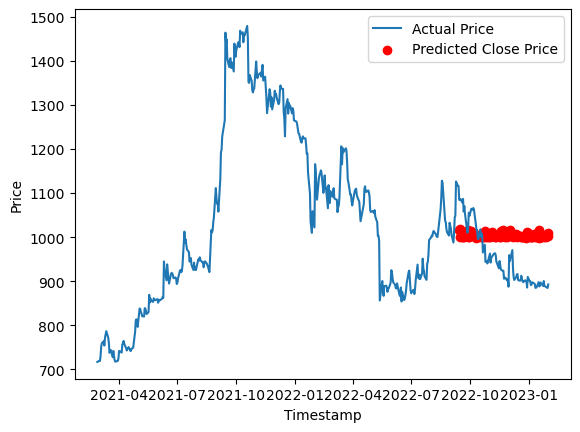

In [3]:
import pandas as pd
import numpy as np

def read_csv(file_path):
    df = pd.read_csv(file_path)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

def clean_df(df):
    #df = df.applymap(lambda x: np.nan if isinstance(x, str) else x)
    #df = df.dropna()
    #df = df[~df.isin([np.inf, -np.inf]).any(1)]
    #df = df.applymap(lambda x: np.nan if x > 1e10 else x)
    df = df.dropna()
    return df

def calculate_indicators(df):
    # 7-day moving average
    df['7_day_ma'] = df['Close Price'].rolling(7).mean()

    # 14-day moving average
    df['14_day_ma'] = df['Close Price'].rolling(14).mean()

    # Bollinger Bands
    df['rolling_std'] = df['Close Price'].rolling(20).std()
    df['upper_band'] = df['14_day_ma'] + 2 * df['rolling_std']
    df['lower_band'] = df['14_day_ma'] - 2 * df['rolling_std']

    # Relative Strength Index (RSI)
    delta = df['Close Price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    df['26_day_ema'] = df['Close Price'].ewm(26).mean()
    df['12_day_ema'] = df['Close Price'].ewm(12).mean()
    df['MACD'] = df['12_day_ema'] - df['26_day_ema']
    df['signal_line'] = df['MACD'].ewm(9).mean()

    # Stochastic Oscillator
    L14 = df['Low Price'].rolling(14).min()
    H14 = df['High Price'].rolling(14).max()
    df['%K'] = 100 * (df['Close Price'] - L14) / (H14 - L14)
    df['%D'] = df['%K'].rolling(3).mean()

    # Average Directional Movement Index (ADX)
    #df['ADX']=calculate_ADX(df, n=14)
    #print("------------------------------------------>",minus_delta,"<--This is--------")

    #Volume Weighted Average Price (VWAP)
    df['Price_times_volume'] = df['Close Price'] * df['Total Traded Quantity']
    df['VWAP'] = df['Price_times_volume'].cumsum() / df['Total Traded Quantity'].cumsum()
    return df

df = read_csv("stock_data.csv");


#print(type(df),"-------------> ",df.head)

#df=clean_df(df)

#print("xx------------------------------------------------------------------------------------------------------------xx ")

#print(type(df),"-------------> ",df.tail(10))


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import pandas as pd
import numpy as np

def read_csv(file_path):
    df = pd.read_csv(file_path)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df


def clean_df(df):
    #df = df.applymap(lambda x: np.nan if isinstance(x, str) else x)
    #df = df.dropna()
    #df = df[~df.isin([np.inf, -np.inf]).any(1)]
    #df = df.applymap(lambda x: np.nan if x > 1e10 else x)
    df = df.dropna()
    return df

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def predict_price(df):
    # Convert the Date column to timestamps and use it as the index
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    print(df.head())
    # Use features lower_band,RSI,26_day_ema,12_day_ema,MACD,signal_line,%K,%D,Price_times_volume,VWAP
    X = df[['Total Traded Quantity']]
    y = df['Close Price']

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    from sklearn.metrics import mean_squared_error

# ...

    models = [LinearRegression(), RandomForestRegressor(random_state=42), SVR()]
    mse_values = []
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_values.append(mse)

    best_model_index = mse_values.index(min(mse_values))
    best_model = models[best_model_index]

# ...

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Fit models and make predictions
#     regressors = {'Random Forest': RandomForestRegressor(random_state=42),
#                   'Support Vector Regression': SVR(),
#                   'Linear Regression': LinearRegression()}
#     for name, regressor in regressors.items():
#         regressor.fit(X_train, y_train)
#         y_pred = regressor.predict(X_test)

        # Predict price movement direction
    y_pred_series = pd.Series(y_pred)
    y_pred_movement = (y_pred_series > y_pred_series.shift(1)).astype(int)
    #print(f"Predicted price: {y_pred[-1]}"){y_pred[-len(y_test):]}
    #print(f"Predicted price: {y_pred[-len(y_test):]}")
    print(f"Predicted price: {y_pred[-1]}")
    #print(f"Expected price movement direction: {'Up' if y_pred_movement[-1] == 1 else 'Down'}")
    if len(y_pred_movement) > 0:
        print(f"Expected price movement direction: {'Up' if y_pred_movement[len(y_pred_movement)-1] == 1 else 'Down'}")
    else:
        print("Unable to determine expected price movement direction")

        #print("------------------------------------------------",len(y_train))

    # Plot actual vs. predicted price
    fig, ax = plt.subplots()
    ax.plot(df.index, y, label='Actual Price')
    ax.scatter(df.index[len(y_train):], y_pred, label='Predicted Close Price', color='red')
#     ax.plot(df.index, df['14_day_ma'], label='MA20')
#     ax.plot(df.index, df['signal_line'], label='Signal Line')
#     ax.plot(df.index, df['RSI'], label='RSI')
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price")
    ax.legend()
    plt.show()
    
    
#     fig, ay = plt.subplots()
#     ay.plot(df.index[len(y_train):], y_pred, label='Predicted Price')
# #     ax.plot(df.index, df['14_day_ma'], label='MA20')
# #     ax.plot(df.index, df['signal_line'], label='Signal Line')
# #     ax.plot(df.index, df['RSI'], label='RSI')
#     ay.set_xlabel("Timestamp")
#     ay.set_ylabel("Price")
#     ay.legend()
#     plt.show()
    
#     fig, ax = plt.subplots()
# ax.plot(df['Timestamp'], df['Close Price'], label='Actual Close Price')
# ax.scatter(df['Timestamp'], y_pred, label='Predicted Close Price', color='red')
# ax.set_xlabel('Timestamp')
# ax.set_ylabel('Close Price')
# ax.legend()
# plt.show()



df=calculate_indicators(df);
df=clean_df(df)
#print(df.head(1))
predict_price(df)
